In [1]:
from train import train_epochs
from gan_toy import Generator, Discriminator
# from utils.utils import *
from utils.exp1 import experiment_save_results, visualize_experiment_dataset, experiment_data
import utils.pytorch_utils as ptu
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook

/Users/maximzubkov/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/maximzubkov/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
def penalty(g, d, real_data, fake_data):
    batch_size = real_data.shape[0]

    eps = torch.rand(batch_size, 1).to(ptu.device)
    interpolated = eps * real_data.data + (1 - eps) * fake_data.data
    interpolated.requires_grad = True

    d_output = d(interpolated)
    gradients = torch.autograd.grad(outputs=d_output, inputs=interpolated,
                                    grad_outputs=torch.ones(d_output.size()).to(ptu.device),
                                    create_graph=True, retain_graph=True)[0]

    l2 = (d_output.reshape(-1) ** 2).mean()
    gradients = gradients.reshape(batch_size, -1)
    gradients_norm = torch.sum(gradients ** 2, dim=1)
    return l2 + gradients_norm.mean() / (4 * np.pi)

In [3]:
n_modes = 3
params = [(2, 0.4),(0, 0.55),(5, 0.25)]

In [4]:
from torch.optim.lr_scheduler import StepLR
import time
delta = []

In [5]:
def exp1(train_data):
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    g = Generator(3, 3, 25, 1).to(ptu.device)
    c = Discriminator(1, 3, 25, 1).to(ptu.device)

    # wasserstein
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - critic(fake_data).mean()
    
    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return critic(fake_data).mean() - critic(x).mean() # + 0.1 * penalty(generator, critic, x, fake_data)
    n_epochs = 100
    c_opt = optim.Adam(c.parameters(), lr=9e-5, betas=(0, 0.9))
    g_opt = optim.Adam(g.parameters(), lr=9e-5, betas=(0, 0.9))
    c_scheduler = torch.optim.lr_scheduler.StepLR(c_opt, step_size=300, gamma=0.9)
    g_scheduler = torch.optim.lr_scheduler.StepLR(g_opt, step_size=50, gamma=0.9)
    train_args = {
        "epochs": n_epochs, 
        "n_critic": 20, 
        "final_snapshot":True,
    }
    result = train_epochs(g, c, g_loss, c_loss, train_loader, train_args, g_opt=g_opt, 
                          c_opt=c_opt, is_spiral=False, modes=n_modes, param_modes=params) #, g_scheduler=g_scheduler, c_scheduler=c_scheduler)
    train_losses, samples_1, samples_final, pvals = result
    return g, c, train_losses, samples_1, samples_final, pvals

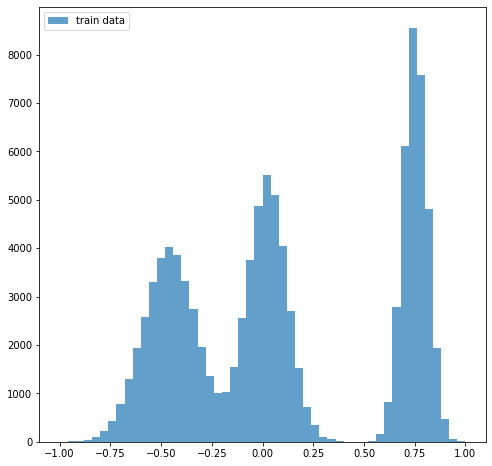

In [6]:
visualize_experiment_dataset(is_spiral=False, modes=n_modes, param_modes=params)

In [7]:
start = time.time()
g, c, train_losses, samples_1, samples_final, pvals = experiment_save_results('a', exp1, "experiment1", 
                                                                              is_spiral=False,
                                                                              modes=n_modes,
                                                                              param_modes=params)
end = time.time()
delta.append(end-start)

KeyboardInterrupt: 

In [ ]:
np.save("./saved_samples/exp1_n_r=2_nosn", g.sample(2000).detach().numpy())

In [45]:
delta

[974.5721538066864]

> Формула для спирали $r(\theta) = a+b\theta$

In [14]:
a = experiment_data(n=1, is_spiral=True, n_modes=3, params=params)

No handles with labels found to put in legend.


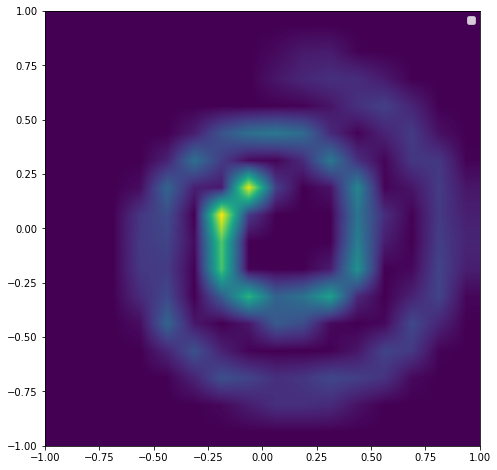

In [15]:
visualize_experiment_dataset(is_spiral=True)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils.pytorch_utils as ptu
from src.sn import SpectralNorm 
from torch.autograd import Variable

In [17]:
opt = {}
opt["img_size"] = 16
opt["latent_dim"] = 32
opt["channels"] = 1

In [18]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt["img_size"] // 4
        self.l1 = nn.Sequential(nn.Linear(opt["latent_dim"], 32 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, opt["channels"], 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 32, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img
    
    def sample(self, n):
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (n, opt["latent_dim"]))).to(ptu.device))
        out = self.l1(z)
        out = out.view(out.shape[0], 32, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img
        


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), 
                     nn.LeakyReLU(0.2, inplace=True)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt["channels"], 16, bn=False),
            *discriminator_block(16, 32),
        )

        # The height and width of downsampled image
        ds_size = opt["img_size"] // 2 ** 2
        self.adv_layer = nn.Linear(32 * ds_size ** 2, 1)

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [19]:
def exp2(train_data):
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    g = Generator().to(ptu.device)
    c = Discriminator().to(ptu.device)
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - critic(fake_data).mean()
    
    def c_loss(generator, critic, x):
        batch_size = x.shape[0]
        fake_data = generator.sample(batch_size)
        return critic(fake_data).mean() - critic(x).mean() #- 0.1 * penalty(generator, critic, x, fake_data)
    n_epochs = 500
    c_opt = optim.Adam(c.parameters(), lr=4e-5, betas=(0, 0.9))
    g_opt = optim.Adam(g.parameters(), lr=2e-5, betas=(0.5, 0.9))
    c_scheduler = torch.optim.lr_scheduler.StepLR(c_opt, step_size=10, gamma=0.8)
    g_scheduler = torch.optim.lr_scheduler.StepLR(g_opt, step_size=10, gamma=0.9)
    train_args = {
        "epochs": n_epochs, 
        "n_critic": 2, 
        "final_snapshot":True
    }
    result = train_epochs(g, c, g_loss, c_loss, train_loader, train_args, g_opt=g_opt, 
                          c_opt=c_opt, is_spiral=True, g_scheduler=g_scheduler, c_scheduler=c_scheduler)
    train_losses, samples_1, samples_final, pvals = result
    return g, c, train_losses['c_losses'], samples_1, samples_final, pvals

In [ ]:
start = time.time()
g, c, *_ = experiment_save_results('a', exp2, 'spiral', is_spiral=True)
end = time.time()
delta.append(end-start)

> 100 epochs, no Spectral Noramlization , $n_{cr} = 2, t = 183.73s$

> 100 epochs, no Spectral Noramlization , $n_{cr} = 4, t = 180.28s$

> 100 epochs, no Spectral Noramlization , $n_{cr} = 4, t = 168.17s$

> 100 epochs, Spectral Noramlization , $n_{cr} = 2, t = 260.13s$

> 100 epochs, Spectral Noramlization , $n_{cr} = 4, t = 234.86s$

> 100 epochs, Spectral Noramlization , $n_{cr} = 6, t = 233.38s$